# Neural network solver for "strato" (34 species) mechanism

This notebook is for my AM216 final project report, so it is more organized and self-contained than other notebooks in this folder (which contain my messy experiments). Besides standard Python modules, the only dependency is the KPP module generated by f2py. For the first time using this code, do:

```
$ cd ./strato_code
$ make kpp4py
```

Random seeds are explicitly specified for all stochastic parts (training data sampling, weight initializaion, SGD...), so all results should be reproducible.



# Preparation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
from ipywidgets import interact, IntSlider

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

torch.__version__ # 0.4 has siginificant API change compared to 0.3

'0.4.0'

In [2]:
import strato_code.kpp4py as kpp # KPP Fortran integrator, compiled by f2py

# get variable names from source code
from read_results import read_varnames # simple ultility function
nvar = 34
varnames = read_varnames("strato_code/strato_Parameters.f90")[0:nvar]
print(varnames)

['CH3', 'Cl2', 'Cl2O2', 'ClOO', 'OClO', 'BrCl', 'HOBr', 'BrONO2', 'HCO', 'CH3O', 'O1D', 'N2O5', 'HBr', 'CH3OOH', 'HNO4', 'HCl', 'H2O2', 'HOCl', 'HNO3', 'H', 'CH3O2', 'ClONO2', 'NO3', 'CH2O', 'Br', 'OH', 'Cl', 'ClO', 'O3', 'NO', 'BrO', 'O', 'HO2', 'NO2']


# Identify the range of input variables

## A single time series

In [3]:
## Parse the Fortran source code to get default initial condition provides by KPP

df_init = pd.Series(data=1e-8, index=varnames)

with open ("strato_code/strato_Initialize.f90", "r") as f:
    code_str = f.readlines()

for i, line in enumerate(code_str):
    if 'VAR(1)' in line:
        startline = i
        break

CFACTOR = 8.120000e+16
for i in range (nvar):
    df_init[i] = eval(code_str[startline+i].split()[-1])
    
df_init.head()

CH3         3.235355
Cl2      7036.531348
Cl2O2    5768.445564
ClOO      215.935647
OClO     5841.169096
dtype: float64

In [4]:
# Integrate forward for multiple time steps
y_history = kpp.forward(df_init.values, 72)
y_history.shape

(35, 72)

In [5]:
df_history = pd.DataFrame(y_history.T, columns=varnames+['SUN'])
df_history.index.name = 'time'
df_history.head()

,CH3,Cl2,Cl2O2,ClOO,OClO,BrCl,HOBr,BrONO2,HCO,CH3O,...,OH,Cl,ClO,O3,NO,BrO,O,HO2,NO2,SUN
time,,,,,,,,,,,,,,,,,,,,,
0,3.234628,6739.494384,5791.628256,217.315939,5844.714250,4751.069052,410747.322915,7623.857356,0.024642,202.797077,...,1.655987e+07,715535.902465,8.235015e+07,5.292275e+11,8.739400e+08,918443.072893,6.590324e+08,1.166693e+07,2.240409e+08,1.000000
1,3.224996,6685.439159,5816.405716,218.173554,5859.333303,4762.888190,409456.999496,7633.898411,0.024619,202.261306,...,1.650100e+07,718359.932959,8.249465e+07,5.259771e+11,8.746498e+08,918391.242797,6.541997e+08,1.162177e+07,2.241613e+08,0.999220
2,3.161609,6802.822195,5883.507207,216.283073,5939.809826,4828.388417,409706.775265,7814.912451,0.024159,198.349859,...,1.621275e+07,712134.147492,8.254032e+07,5.224611e+11,8.727696e+08,919652.457798,6.374849e+08,1.147695e+07,2.264624e+08,0.987575
3,2.917805,7357.660661,6122.898412,205.454262,6274.013759,5100.617745,415386.392560,8663.252882,0.022349,183.162555,...,1.513317e+07,676473.263380,8.232835e+07,5.173035e+11,8.620172e+08,925248.039594,5.804342e+08,1.098227e+07,2.369791e+08,0.938153
4,2.353436,9050.498768,6782.410995,177.939929,7255.742131,5900.595317,433599.474331,11445.999688,0.018151,147.913039,...,1.253191e+07,585865.163704,8.144778e+07,5.090709e+11,8.297395e+08,937897.232885,4.539145e+08,9.793042e+06,2.677609e+08,0.813302


/Users/zhuangjw/Research/Computing/miniconda3/envs/geo/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/Users/zhuangjw/Research/Computing/miniconda3/envs/geo/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


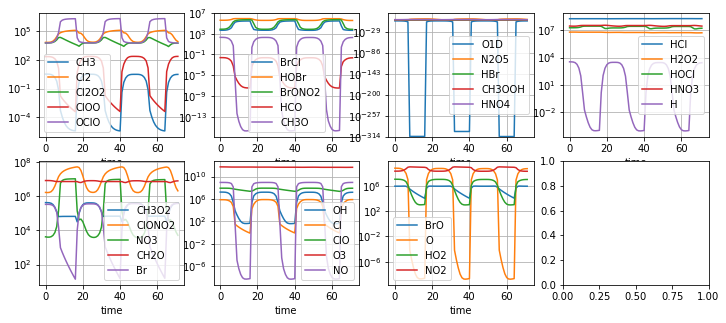

In [6]:
N_sub = 5 
N_figures = 8

fig, axes = plt.subplots(2, 4, figsize=[12, 5])

for i in range(N_figures-1):
    sub_name = varnames[i*N_sub:(i+1)*N_sub]
    df_history.plot(y=sub_name, logy=True, grid=True, ax=axes.ravel()[i])

In [7]:
df_range = df_history.agg(['min', 'max']).T
df_range.clip_lower(1e-8, inplace=True) # prevent small negative values
df_range.head()

,min,max
CH3,0.000004,3.234628e+00
Cl2,6685.439159,1.245632e+05
Cl2O2,2478.591353,2.227402e+04
ClOO,0.000377,2.320970e+02
OClO,5689.835489,2.060717e+06


## Random sampling from the above range to get y0

In [8]:
N_train = 5000 # Number of training data. To use more training data, should train on GPU instead.

np.random.seed(42)
y0_list =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_train, nvar+1))
y0_list.shape

(5000, 35)

## Integrate for one step (from y0 to y1) to get realistic correlation

In [9]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 1.34 s, sys: 16.3 ms, total: 1.35 s
Wall time: 1.39 s


(5000, 34)

In [10]:
df_y1 = pd.DataFrame(y1_list, columns=varnames)
df_y1.head()

,CH3,Cl2,Cl2O2,ClOO,OClO,BrCl,HOBr,BrONO2,HCO,CH3O,...,Br,OH,Cl,ClO,O3,NO,BrO,O,HO2,NO2
0,2.832107,10100.718369,3789.309894,178.055356,4871.038104,3965.070064,398008.613548,8209.880233,0.020632,177.690062,...,339630.248554,1.552674e+07,586268.580903,6.597581e+07,4.927944e+11,9.208565e+08,924841.720503,5.802867e+08,1.085895e+07,2.242885e+08
1,2.819576,8399.653841,6181.384883,181.899995,4898.946658,3966.544112,328499.941921,3116.227325,0.019589,175.122849,...,253537.857580,1.497442e+07,598925.265549,8.490917e+07,4.736637e+11,4.446975e+08,734542.934890,5.775390e+08,1.148592e+07,1.137226e+08
2,2.474219,39369.059433,5558.100862,180.012553,4977.436712,4027.994356,320414.640814,5180.854000,0.017752,154.423033,...,261860.373285,1.331259e+07,592716.246698,7.844063e+07,4.411261e+11,6.447727e+08,744101.506390,4.698142e+08,1.011196e+07,1.728652e+08
3,2.896576,39610.519615,3443.106638,200.100180,4296.359444,3488.217877,343264.094486,9116.088456,0.020337,182.111824,...,343396.680855,1.560521e+07,658874.706064,6.387729e+07,4.703776e+11,1.176493e+09,847777.439779,5.603705e+08,1.027233e+07,2.763206e+08
4,1.431758,41776.197550,3658.983220,103.245214,6195.591069,5029.329429,439354.466834,14991.002367,0.010895,89.877862,...,247858.019071,8.914400e+06,339923.690983,5.575415e+07,4.353463e+11,7.081671e+08,932064.305275,2.708341e+08,7.797922e+06,2.484516e+08


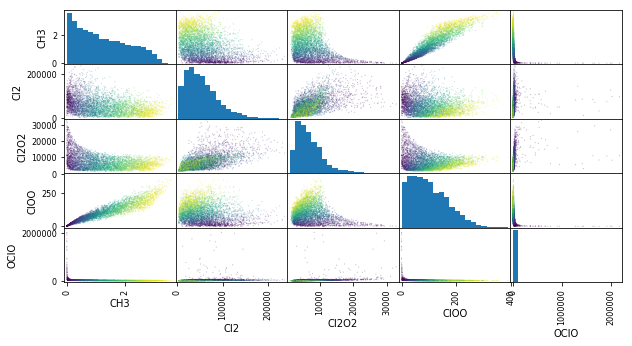

In [11]:
# just plot a subset of species
pd.plotting.scatter_matrix(df_y1.iloc[:,:5], c=y0_list[:,-1], figsize=(10, 5), alpha=0.3, s=5, hist_kwds={'bins': 20});
# color is SUN intensity at the previous time step

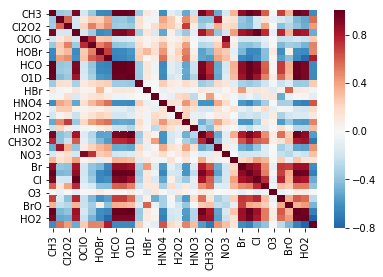

In [12]:
sns.heatmap(df_y1.corr(), cmap='RdBu_r', center=0.0)
# very strong correlation between species after reaction
# note that the correlation before integration (y0) is zero, due to random sampling

## See if the distribution of y1 is representative enough

In [13]:
# Integrate for one more step to see if there's any significant change in species distribution
np.random.seed(41)
SUN_new = np.random.rand(N_train, 1) # use new sun intensity
%time y2_list = kpp.onestep(np.c_[y1_list, SUN_new].T).T  
y2_list.shape

CPU times: user 878 ms, sys: 9.77 ms, total: 888 ms
Wall time: 893 ms


(5000, 34)

In [14]:
# No significant change in species distribution
# Too many species, better explore interactively
@interact(n=IntSlider(min=0,max=nvar-1,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=33), Output()), _dom_classes=('widget-interact',…

## Estimate the dimensionality of manifold

Use PCA as a quick and dirty estimate. Any better (non-linear) dimensionality estimate algorithm?

In [15]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [16]:
# Normalize data and apply PCA
# http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
Normed_PCA = lambda : make_pipeline(StandardScaler(), PCA(n_components=10))

In [17]:
def print_PCA(y_list):
    pca = Normed_PCA()
    pca.fit(y_list)
    ratio = pca.named_steps['pca'].explained_variance_ratio_
    print('Explained variance: \n', ratio)
    print('Accumulated: \n', np.cumsum(ratio))

In [18]:
print_PCA(y0_list) # evenly distributed due to uniform sampling

Explained variance: 
 [0.03208784 0.03158881 0.03143785 0.03121533 0.03062335 0.03021648
 0.03016956 0.03006537 0.029901   0.02962053]
Accumulated: 
 [0.03208784 0.06367664 0.09511449 0.12632982 0.15695317 0.18716965
 0.21733921 0.24740458 0.27730558 0.30692611]


In [19]:
print_PCA(y1_list) # Dominated by the first 5 components

Explained variance: 
 [0.45079355 0.09468526 0.07862922 0.05923362 0.05453957 0.03695391
 0.02926002 0.02788998 0.02548369 0.02400006]
Accumulated: 
 [0.45079355 0.54547881 0.62410803 0.68334165 0.73788122 0.77483513
 0.80409515 0.83198513 0.85746883 0.88146889]


In [20]:
print_PCA(y2_list) # No Significant change compared to y2

Explained variance: 
 [0.45537063 0.10791311 0.09831238 0.06227755 0.05926653 0.03549616
 0.03336649 0.0233735  0.02271934 0.02045371]
Accumulated: 
 [0.45537063 0.56328374 0.66159613 0.72387368 0.78314021 0.81863637
 0.85200286 0.87537636 0.89809571 0.91854941]


# Preprocessing

Neural network requires input features to be normalized.

In [21]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:nvar]) # skip SUN, which is already in 0~1

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
X_train = np.c_[normalizer.transform(y1_list[:,0:nvar]), SUN_new]
X_train.shape

(5000, 35)

In [23]:
Y_train = normalizer.transform(y2_list) # use y1's scale
Y_train.std(axis=0) # highly normalized since y1 and y2 have similar distribution.

array([1.01141266, 0.9845124 , 1.22657515, 1.02708392, 0.61923467,
       0.78024653, 1.08184242, 0.69377157, 1.01372966, 1.01149575,
       1.00163322, 0.83854094, 1.42956594, 1.40028166, 1.0221581 ,
       1.19220296, 0.99470165, 1.00545799, 1.19383952, 0.99975191,
       1.01185847, 0.86279131, 0.79292158, 1.03476078, 1.00868456,
       1.01112199, 1.0270981 , 0.95080187, 0.98753625, 1.01723394,
       0.93125453, 1.00244347, 1.03626437, 1.02353825])

# ANN training

In [24]:
# will make a copy from float64 to float32. 
# use torch.from_numpy() to share the same memory.
x_torch = torch.from_numpy(X_train)
y_torch = torch.from_numpy(Y_train)

In [25]:
# two-hidden-layer net performs significantly better than one-hidden-layer net
def two_layer_net(H=100):
    model = torch.nn.Sequential(
        torch.nn.Linear(nvar+1, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, nvar)
    )
    return model 

In [26]:
# weight initialization has no significant effect
# presumably because the net is quite small so it is easy to find minimum
torch.manual_seed(40) 
model = two_layer_net().double() # L-BFGS doesn't work at single precision. Not sure why.

In [27]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters())
for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.item())

20 0.0024780154784195207
40 0.0009879519036642016
60 0.0005843731634507236
80 0.0004059098425036157
100 0.00030527145385724906
120 0.00024430256096743717
140 0.00020627707574398925
160 0.0001782750614676689
180 0.00015753548656607865
200 0.00014134931386577775
CPU times: user 7min 30s, sys: 14.7 s, total: 7min 45s
Wall time: 2min 45s


In [28]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.detach().numpy() # 60x faster than KPP

CPU times: user 53.9 ms, sys: 3.38 ms, total: 57.3 ms
Wall time: 23.7 ms


In [29]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.9999864 , 0.99951643, 0.99988151, 0.99994752, 0.99939306,
       0.99948034, 0.99985263, 0.99964565, 0.99995651, 0.99998409,
       0.99997466, 0.99985217, 0.99992081, 0.99988736, 0.99981498,
       0.99992129, 0.99984014, 0.99984181, 0.99991168, 0.99994315,
       0.99959777, 0.99987448, 0.99955091, 0.99983577, 0.99990284,
       0.99997664, 0.99994795, 0.99989925, 0.999924  , 0.99991679,
       0.99982173, 0.99997131, 0.99988281, 0.99988689])

In [30]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9998639030184364

## Scale-back to original concentration

In [31]:
y_pred_origin = normalizer.inverse_transform(y_pred_numpy)

In [32]:
def error_norm(y, y_true):
    """L1 error norm"""
    abserr = (np.abs(y - y_true)).mean(axis=0)
    return abserr/y_true.mean(axis=0)

In [33]:
error_norm(y_pred_origin, y2_list) # train error varies across species

array([1.96429725e-03, 1.03538926e-02, 4.71920660e-03, 3.37676351e-03,
       3.44989929e-02, 1.67222552e-02, 2.83713658e-03, 1.56203638e-02,
       3.29309168e-03, 2.08934440e-03, 3.46167418e-03, 6.51647194e-03,
       6.91657845e-04, 1.12990543e-03, 3.14279763e-03, 8.71673203e-05,
       5.14029019e-04, 2.08381711e-03, 6.97123907e-04, 6.03032997e-03,
       7.77397914e-03, 5.15767461e-03, 4.98055994e-02, 6.23097905e-04,
       4.27974925e-03, 2.47318374e-03, 3.36786246e-03, 1.87304738e-03,
       3.66213060e-04, 3.06340944e-03, 2.42683146e-03, 3.01363092e-03,
       3.01791837e-03, 4.39561237e-03])

## Accuracy on test set

In [34]:
N_test = 10000

np.random.seed(39)
y0_test =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_test, nvar+1))
%time y1_test = kpp.onestep(y0_test.T).T
y1_test.shape # this is the initial condition

CPU times: user 2.77 s, sys: 21 ms, total: 2.79 s
Wall time: 2.72 s


(10000, 34)

In [35]:
np.random.seed(38)
SUN_test = np.random.rand(N_test, 1) # use new sun intensity
%time y2_test = kpp.onestep(np.c_[y1_test, SUN_test].T).T
y2_test.shape

CPU times: user 1.73 s, sys: 13.2 ms, total: 1.74 s
Wall time: 1.74 s


(10000, 34)

In [36]:
X_test = np.c_[normalizer.transform(y1_test), SUN_test]
Y_test = normalizer.transform(y2_test) # true result for comparison
Y_test_pred = model(torch.from_numpy(X_test)).detach().numpy()

In [37]:
r2_test = r2_score(Y_test_pred, Y_test, multioutput='raw_values')
r2_test 

array([0.99998211, 0.99900338, 0.99974993, 0.99991827, 0.88683364,
       0.99772351, 0.99970532, 0.99918983, 0.99994856, 0.99997749,
       0.99997253, 0.9997838 , 0.99987375, 0.99958762, 0.99971058,
       0.99988975, 0.99975132, 0.99978668, 0.99986929, 0.99993398,
       0.99907418, 0.99982102, 0.81913325, 0.99971835, 0.99987803,
       0.99997432, 0.99992021, 0.99986157, 0.99989031, 0.9998817 ,
       0.9996448 , 0.99996909, 0.99986125, 0.99982722])

In [38]:
r2_test.min(), r2_test.argmin() # for worse case

(0.819133254983591, 22)

In [39]:
varnames[22] # NO3 has a weird, long-tail probability distribution, so has much larger error.

'NO3'

In [40]:
r2_score(Y_test_pred, Y_test, multioutput='variance_weighted')

0.9959551393611124

In [41]:
y2_test_pred = normalizer.inverse_transform(Y_test_pred)
y2_test_pred.shape

(10000, 34)

In [42]:
L1_test = error_norm(y2_test_pred, y2_test) # test error varies across species
L1_test

array([2.08944832e-03, 1.22577875e-02, 5.40773178e-03, 3.70593921e-03,
       8.92793226e-02, 2.17704405e-02, 3.19392659e-03, 1.81289321e-02,
       3.41998186e-03, 2.22323009e-03, 3.50525513e-03, 7.13486126e-03,
       7.81267282e-04, 1.38246687e-03, 3.56851226e-03, 9.63341032e-05,
       5.82357072e-04, 2.29072470e-03, 7.77828008e-04, 6.25426785e-03,
       8.80974847e-03, 5.75505982e-03, 1.49489379e-01, 7.04107683e-04,
       4.62095509e-03, 2.52785231e-03, 3.69968577e-03, 2.06780226e-03,
       4.07671379e-04, 3.34683984e-03, 2.69156155e-03, 3.03678739e-03,
       3.12920795e-03, 4.70620578e-03])

In [43]:
L1_test.mean()

0.011260102323609274

In [44]:
L1_test.max(), L1_test.argmax()

(0.14948937861652534, 22)

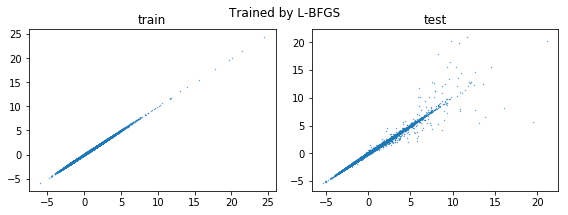

In [45]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(y_pred_numpy, Y_train, s=0.1)
axes[0].set_title('train')
axes[1].scatter(Y_test_pred, Y_test, s=0.1)
axes[1].set_title('test')

fig.suptitle('Trained by L-BFGS')
fig.tight_layout()

In [46]:
# Interactively plot the error for each species
# Most species are highly accurate
# Use NO3 with the largest error as default
@interact(i_var=IntSlider(min=0,max=nvar-1,step=1,value=22,continuous_update=True))
def plot_one_species(i_var):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    axes[0].scatter(y_pred_numpy[:,i_var], Y_train[:,i_var], alpha=0.5, s=1)
    axes[0].set_title('train')
    axes[1].scatter(Y_test_pred[:,i_var], Y_test[:,i_var], alpha=0.5, s=1)
    axes[1].set_title('test')
    fig.suptitle(varnames[i_var])

interactive(children=(IntSlider(value=22, description='i_var', max=33), Output()), _dom_classes=('widget-inter…

In [47]:
sub_index = list(range(nvar))
sub_index.remove(4)
sub_index.remove(22)

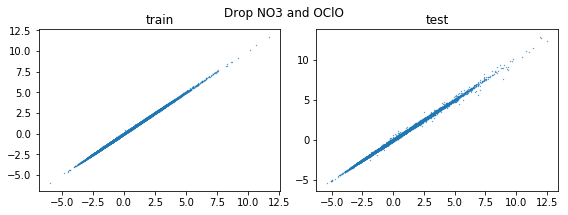

In [48]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(y_pred_numpy[:,sub_index], Y_train[:,sub_index], s=0.1)
axes[0].set_title('train')
axes[1].scatter(Y_test_pred[:,sub_index], Y_test[:,sub_index], s=0.1)
axes[1].set_title('test')

fig.suptitle('Drop NO3 and OClO')
fig.tight_layout()

# Optimizer effect

## Full-batch gradient descent

In [49]:
torch.manual_seed(40) # use the same initial weight as L-BFGS case 
model_GD = two_layer_net().double()

In [50]:
%%time
def training_GD(model):
    """
    training data x_torch and y_torch are global variables
    Juse to avoid mess-up existing global variables (y_pred, optimizer, loss...)
    """
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for t in range(4000): # takes roughly the same time as 200 steps of L-BFGS
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        optimizer.step()

        if (t+1)%500==0:
            # no need to re-evaluate loss, unlike BFGS
            print(t+1, loss.item())

training_GD(model_GD)

500 0.05553377809063258
1000 0.02478594459665523
1500 0.012348927860888436
2000 0.006372900931119665
2500 0.003756358259517617
3000 0.002701835363729014
3500 0.002063300654264144
4000 0.0017590532333228734
CPU times: user 6min 33s, sys: 23.6 s, total: 6min 57s
Wall time: 2min 24s


In [51]:
# training accuracy
Y_train_pred_GD = model_GD(x_torch).detach().numpy()
r2_score(Y_train_pred_GD, Y_train, multioutput='raw_values')

array([0.99980898, 0.99733016, 0.99869515, 0.999553  , 0.96184065,
       0.99533501, 0.9985927 , 0.99760667, 0.9997487 , 0.99980397,
       0.99970748, 0.9986111 , 0.99914473, 0.99876982, 0.99853762,
       0.99902364, 0.99843279, 0.99865188, 0.99897648, 0.99942256,
       0.99809401, 0.99864286, 0.98157926, 0.99864181, 0.99939632,
       0.99975258, 0.99955274, 0.99916667, 0.99892212, 0.99913621,
       0.99857531, 0.99974215, 0.99950133, 0.99912662])

In [52]:
error_norm(normalizer.inverse_transform(Y_train_pred_GD), y2_list) 

array([0.00739043, 0.02495992, 0.01529904, 0.00999205, 0.17331184,
       0.04423761, 0.00871774, 0.03783833, 0.00819466, 0.0074652 ,
       0.01163955, 0.01992044, 0.00223369, 0.00367101, 0.00932325,
       0.00031436, 0.00170586, 0.00644441, 0.00242242, 0.01827281,
       0.01751633, 0.01707326, 0.2422858 , 0.00186292, 0.01105758,
       0.00832878, 0.01000738, 0.00555252, 0.00137844, 0.0104112 ,
       0.00691373, 0.00910178, 0.00707676, 0.01225656])

In [53]:
# test accuracy
Y_test_pred_GD = model_GD(torch.from_numpy(X_test)).detach().numpy()
r2_score(Y_test_pred_GD, Y_test, multioutput='raw_values')

array([ 0.99967852,  0.99628758,  0.99787578,  0.99939387, -0.51043292,
        0.94069407,  0.99775038,  0.99554389,  0.99963599,  0.99967529,
        0.99947688,  0.99799895,  0.99857498,  0.9972986 ,  0.99778682,
        0.99860223,  0.99747893,  0.9980515 ,  0.99843323,  0.99901503,
        0.99640295,  0.99809628, -0.59313266,  0.99801942,  0.99907   ,
        0.99963651,  0.99939435,  0.99885963,  0.9983621 ,  0.99864549,
        0.99690796,  0.99956023,  0.99933744,  0.99844814])

In [54]:
L1_test_GD = error_norm(normalizer.inverse_transform(Y_test_pred_GD), y2_test)
L1_test_GD

array([8.41639431e-03, 2.83135730e-02, 1.75691600e-02, 1.09671900e-02,
       3.51322849e-01, 7.63580200e-02, 9.87743110e-03, 4.33529825e-02,
       8.99094922e-03, 8.40430617e-03, 1.30140869e-02, 2.17449232e-02,
       2.60934570e-03, 4.32955618e-03, 1.05607196e-02, 3.51124950e-04,
       1.98629857e-03, 7.20646859e-03, 2.80773495e-03, 2.04876083e-02,
       1.98599868e-02, 1.92812694e-02, 5.44577867e-01, 2.10506748e-03,
       1.22253281e-02, 9.00998015e-03, 1.09720897e-02, 6.09114703e-03,
       1.52834830e-03, 1.18055717e-02, 8.44073476e-03, 1.01510969e-02,
       7.59203785e-03, 1.41831638e-02])

In [55]:
L1_test_GD.mean()

0.03901454149117927

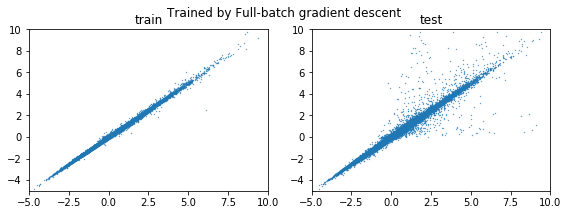

In [56]:
# Not Good!
fig, axes = plt.subplots(1, 2, figsize=[8, 3])

axes[0].scatter(Y_train_pred_GD, Y_train, s=0.1)
axes[0].set_title('train')
axes[0].set_xlim(-5, 10); axes[0].set_ylim(-5, 10)

axes[1].scatter(Y_test_pred_GD, Y_test, s=0.1)
axes[1].set_title('test')
axes[1].set_xlim(-5, 10); axes[1].set_ylim(-5, 10)

fig.suptitle('Trained by Full-batch gradient descent')
fig.tight_layout()

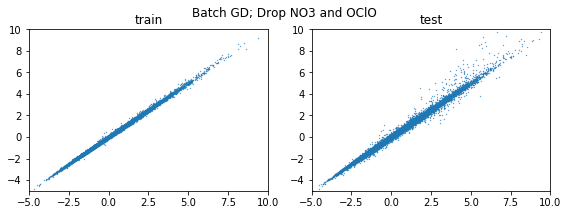

In [57]:
# Really bad!
fig, axes = plt.subplots(1, 2, figsize=[8, 3])

axes[0].scatter(Y_train_pred_GD[:,sub_index], Y_train[:,sub_index], s=0.1)
axes[0].set_title('train')
axes[0].set_xlim(-5, 10); axes[0].set_ylim(-5, 10)

axes[1].scatter(Y_test_pred_GD[:,sub_index], Y_test[:,sub_index], s=0.1)
axes[1].set_title('test')
axes[1].set_xlim(-5, 10); axes[1].set_ylim(-5, 10)

fig.suptitle('Batch GD; Drop NO3 and OClO')
fig.tight_layout()

## Mini-batch SGD

In [58]:
from torch.utils.data import DataLoader, TensorDataset # needed by SGD

In [59]:
torch.manual_seed(40) # use the same initial weight as L-BFGS case 
model_SGD = two_layer_net().double()

In [60]:
%%time
def training_SGD(model, batch_size=128, n_epoch=1200, i_print=150):
    """Use global x_torch and y_torch"""
    dataloader = DataLoader(dataset=TensorDataset(x_torch, y_torch), batch_size=batch_size, shuffle=True)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(n_epoch):
        
        for step, (batch_x, batch_y) in enumerate(dataloader): 
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()

        if (epoch+1)%i_print==0:
            print(epoch+1, loss.item()) # this is just the average loss on a mini-batch

torch.manual_seed(37) # deterministic shuffling
training_SGD(model_SGD)

150 0.003777036303521882
300 0.0032283074053505397
450 0.001496528677659332
600 0.0011518050761955682
750 0.0008484279069211865
900 0.0007125681884628053
1050 0.0012391094914353466
1200 0.0006445107595645095
CPU times: user 6min 8s, sys: 4.45 s, total: 6min 12s
Wall time: 2min 10s


In [61]:
# training accuracy
Y_train_pred_SGD = model_SGD(x_torch).detach().numpy()
r2_score(Y_train_pred_SGD, Y_train, multioutput='raw_values')

array([0.99989892, 0.99756473, 0.99965722, 0.99964436, 0.99892821,
       0.99878923, 0.99951091, 0.99924535, 0.99986555, 0.99990581,
       0.9998747 , 0.99911585, 0.99923037, 0.99889457, 0.99902491,
       0.99766686, 0.99936835, 0.9994079 , 0.99865891, 0.99975018,
       0.99932396, 0.99938056, 0.99877088, 0.99938528, 0.99965984,
       0.99990589, 0.99964447, 0.99949676, 0.99929434, 0.99955855,
       0.99955018, 0.9998926 , 0.99980531, 0.99968448])

In [62]:
error_norm(normalizer.inverse_transform(Y_train_pred_SGD), y2_list) # ~2% error

array([0.00552923, 0.02987705, 0.00834865, 0.00967562, 0.04144316,
       0.02419141, 0.00537323, 0.02485597, 0.00598842, 0.00523763,
       0.00733295, 0.01668202, 0.00232056, 0.00405558, 0.00854149,
       0.00053354, 0.00112127, 0.00427422, 0.00288722, 0.01221415,
       0.01174894, 0.01218033, 0.07665895, 0.00131758, 0.00870223,
       0.00513178, 0.00967036, 0.00464796, 0.00118567, 0.00761565,
       0.00399888, 0.00575339, 0.00429713, 0.00728964])

In [63]:
# test accuracy
Y_test_pred_SGD = model_SGD(torch.from_numpy(X_test)).detach().numpy()
r2_score(Y_test_pred_SGD, Y_test, multioutput='raw_values')

array([ 0.99985541,  0.99701644,  0.99930575,  0.9995736 , -0.02391614,
        0.98851696,  0.99903686,  0.99820032,  0.99981205,  0.99986568,
        0.99978855,  0.99878657,  0.99901288,  0.99776019,  0.99863831,
        0.99752082,  0.9989627 ,  0.99909641,  0.99838905,  0.99958633,
        0.9981407 ,  0.99911634, -0.16257159,  0.99899537,  0.99951852,
        0.99986909,  0.99957379,  0.99934011,  0.99900929,  0.99942072,
        0.99913845,  0.9998178 ,  0.9997283 ,  0.99951219])

In [64]:
L1_test_SGD = error_norm(normalizer.inverse_transform(Y_test_pred_SGD), y2_test) 
L1_test_SGD 

array([0.00599116, 0.03183774, 0.00970078, 0.01014552, 0.18506715,
       0.03672608, 0.00625263, 0.02940625, 0.00644466, 0.00565888,
       0.00822396, 0.01822458, 0.00246146, 0.00458888, 0.00930669,
       0.00054803, 0.00129242, 0.00484437, 0.00307501, 0.01366572,
       0.01401547, 0.01403172, 0.28899525, 0.00149055, 0.0094356 ,
       0.00556395, 0.01014007, 0.00503349, 0.00130689, 0.00829576,
       0.00465503, 0.00644017, 0.00472454, 0.00822885])

In [65]:
L1_test_SGD.mean()

0.02281821462748336

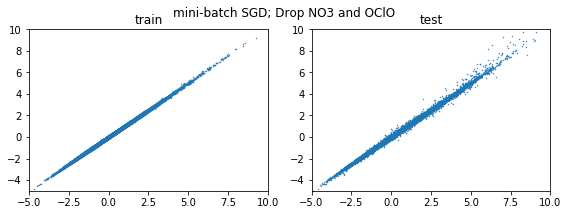

In [66]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])

axes[0].scatter(Y_train_pred_SGD[:,sub_index], Y_train[:,sub_index], s=0.2)
axes[0].set_title('train')
axes[0].set_xlim(-5, 10); axes[0].set_ylim(-5, 10)

axes[1].scatter(Y_test_pred_SGD[:,sub_index], Y_test[:,sub_index], s=0.2)
axes[1].set_title('test')
axes[1].set_xlim(-5, 10); axes[1].set_ylim(-5, 10)

fig.suptitle('mini-batch SGD; Drop NO3 and OClO')
fig.tight_layout()

# ANN prediction for multiple time steps

In [67]:
SUN_history = df_history['SUN']
SUN_history.shape

(72,)

In [68]:
X0 = np.c_[normalizer.transform(y1_test), np.ones(10000)*SUN_history[0]]

In [69]:
def predict_multistep(y_init, Nt, model=model):
    '''
    y_init : [n_sample, nvar]
    Use global variable SUN_history as the forcing term'''    
    N_sample = y_init.shape[0] # N_sample*Nt should not be too large
    Y_history = np.empty([Nt, N_sample, nvar])
    
    X = np.c_[normalizer.transform(y_init), np.ones(N_sample)*SUN_history[0]]
    for t in range(Nt-1):
        Y = model(torch.from_numpy(X)).detach().numpy()
        Y_history[t] = Y # record normalized result. Need to scale back later
        
        X = np.c_[Y, np.ones(N_sample)*SUN_history[t]]

    return Y_history

In [70]:
n_sample = 500
n_time = 10
%time y_pred_test_history = predict_multistep(y1_test[0:n_sample,:], n_time)
#normalizer.inverse_transform(y_pred_test_history, copy=False)
y_pred_test_history.shape

CPU times: user 37.2 ms, sys: 1.96 ms, total: 39.2 ms
Wall time: 30 ms


(10, 500, 34)

In [71]:
%%time
y_test_history = np.empty_like(y_pred_test_history)
for i in range(n_sample):
    y_test_history[:,i,:] = kpp.forward(y1_test[i,:], n_time).T[:, :-1]
normalizer.transform(y_test_history.reshape(-1, nvar), copy=False);

CPU times: user 1.13 s, sys: 16.3 ms, total: 1.15 s
Wall time: 995 ms


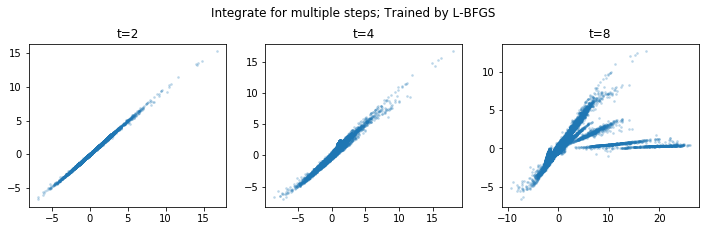

In [72]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 4, 8]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_pred_test_history[t], s=3, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by L-BFGS', y=1.05)

## Use SGD-trained model to predict multi-steps

In [73]:
y_SGD_history = predict_multistep(y1_test[0:n_sample,:], n_time, model=model_SGD)

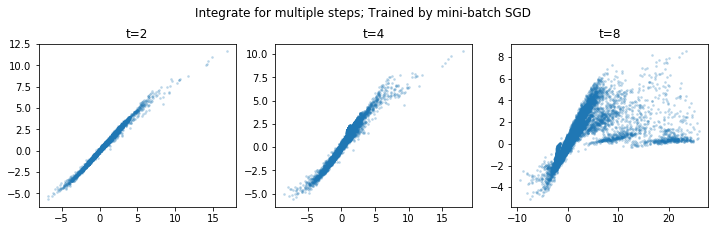

In [74]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 4, 8]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_SGD_history[t], s=3, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by mini-batch SGD', y=1.05)